In [68]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, minmax_scale

import scipy.ndimage

In [69]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [195]:

with h5py.File('/mnt/c/Users/conor/Google Drive/PhD/Core4_Upsample.mat', 'r') as f:
    print(f.keys())

    core = 1-np.array(f['Core4_Area1'])
    ir = np.array(f['IR_Area1'])
    wns = np.array(f['wn1'])

<KeysViewHDF5 ['Core4_Area1', 'IR_Area1', 'wn1']>


In [196]:
scaler = RobustScaler()

x_train, x_test = train_test_split(scaler.fit_transform(ir.T.reshape(-1, wns.shape[1])))
#x_train, x_test = train_test_split(ir.T.reshape(-1, wns.shape[1]))

In [198]:
latent_dim = 16

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Input(x_train.shape[1]),
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(x_train.shape[1])
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [199]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [200]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
7161/7161 [==============================] - 32s 4ms/step - loss: 0.0073 - val_loss: 0.0027
Epoch 2/5
7161/7161 [==============================] - 33s 5ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 3/5
7161/7161 [==============================] - 32s 4ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 4/5
7161/7161 [==============================] - 33s 5ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 5/5
7161/7161 [==============================] - 34s 5ms/step - loss: 8.1213e-04 - val_loss: 7.7905e-04


In [201]:
encoded = autoencoder.encoder(scaler.transform(ir.T.reshape(-1, wns.shape[1]))).numpy()
#encoded = autoencoder.encoder(ir.T.reshape(-1, wns.shape[1])).numpy()

In [202]:
core_scaled = minmax_scale(core.T.reshape(-1,1), feature_range=(encoded[:,1:].min(), encoded[:,1:].max()))

In [203]:
encoded[0]

array([0.10518542, 5.831316  , 1.0647999 , 0.9229881 , 0.17444003,
       1.4079652 , 0.6365525 , 0.        , 1.2927667 , 2.822132  ,
       0.        , 3.9188259 , 0.        , 0.12732212, 1.1245763 ,
       1.9675148 ], dtype=float32)

In [204]:
stacked = np.concatenate([core_scaled.T.reshape(-1,1), encoded[:,1:]], axis=1)
#stacked = encoded

In [205]:
mapped = autoencoder.decoder(stacked).numpy()
up_scaled = mapped.reshape(ir.T.shape)

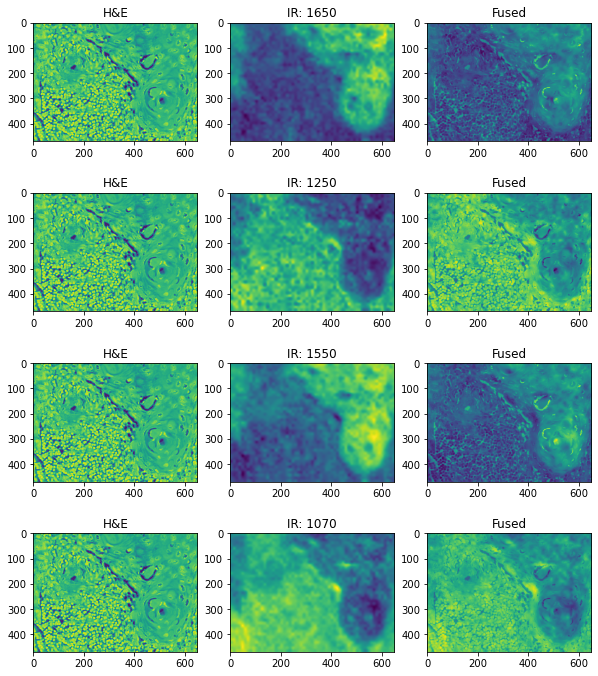

In [209]:
wns_ = [1650, 1250, 1550, 1070]

fig, rows = plt.subplots(figsize=(10, 3*len(wns_)), ncols = 3, nrows = len(wns_))

for wn, cols in zip(wns_, rows):

    wni = np.argmin([np.abs(wn - i) for i in wns.squeeze()])

    for title, col, im in zip(['H&E',f'IR: {wn}','Fused'], cols, [core.T, ir[wni,:,:].T, up_scaled[:,:,wni]]):

        col.set_title(title)
        col.imshow(im)

fig.savefig('./Fusion_Results.pdf')

In [218]:
np.random.randint(0,7000,5)

array([5433, 6394,  691, 4526, 3359])

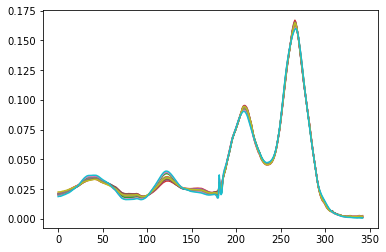

In [222]:
plt.plot(scaler.inverse_transform(mapped)[np.random.randint(0,7000,10), :].T)